## Geometry

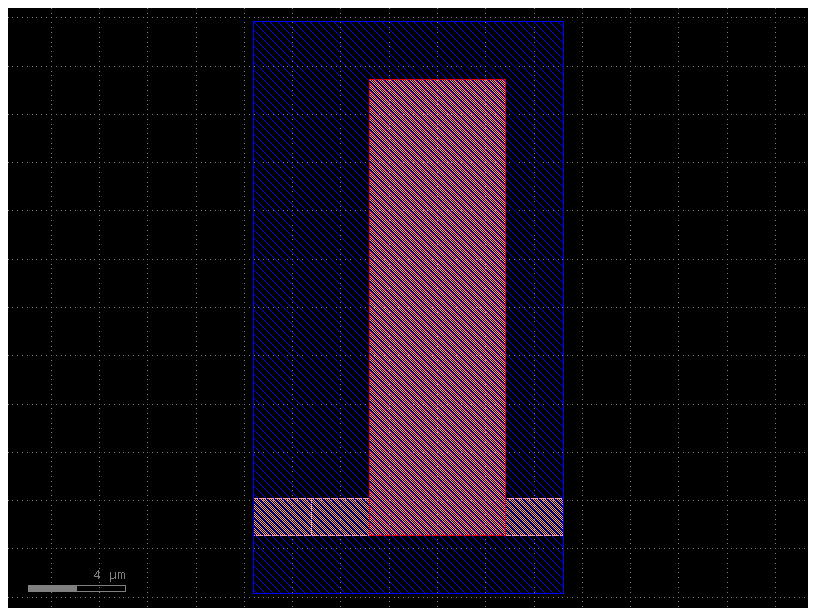

In [9]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import os

path = os.path.join("runs", "stub_opt")

# length and frequency units are arbitrary
frequency = 3  # GHz
wl1f = 300  # vacuum wavelength at 1 unit of frequency in your units
wavelength = wl1f / frequency  # characteristic wavelength

filter_bandwidth = 0.5
frequencies=fs1, fc1,_, fc2, fs2 = (
    2,
    frequency - filter_bandwidth / 2,
    frequency,
    frequency + filter_bandwidth / 2,
    4,
)

# microstrip
height_sub = 0.8  # mm
margin = 3 * height_sub
w_line = 1.52  # mm
l_line = margin
thickness = 0.2  # mm

c = 87.5 / 139  # relative signal speed, from microstrip calculator
signal_wavelength = wavelength * c  # mm

l_design = 1.2 * signal_wavelength / 4
w_design =.3*l_design 

WG = 1,0
BBOX = 10, 0
DESIGN = 20, 0

c = gf.Component()
dut = lumi.mimo(
    l=w_design,
    w=l_design,
    west=[w_line / 2],
    east=[l_design - w_line / 2],
    width_wg=w_line,
    length_wg=l_line,
    init=1,  # solid slab
    layer_wg=WG,
    layer_design=DESIGN,
    centered=True,
)
info = {"designs": [{"ports": dut.info.ports}]}
dut = c << dut

lateral_port_margin = margin
height_port_margin =margin
source_port_margin =  margin

ext = c << gf.components.straight(source_port_margin, width=w_line)
ext.connect("o2", dut.ports["o1"])
c.add_port(f"o1", port=dut.ports[f"o1"])
c.add_port(f"o2", port=dut.ports[f"o2"])

c << gf.components.bbox(component=c, layer=BBOX, top=margin, bottom=margin)
c.plot()

## Solve

Solving port modes with FEM...


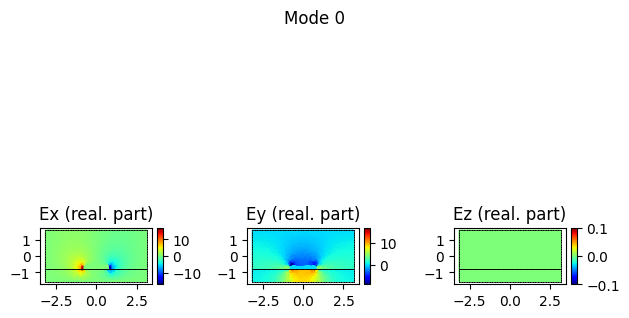

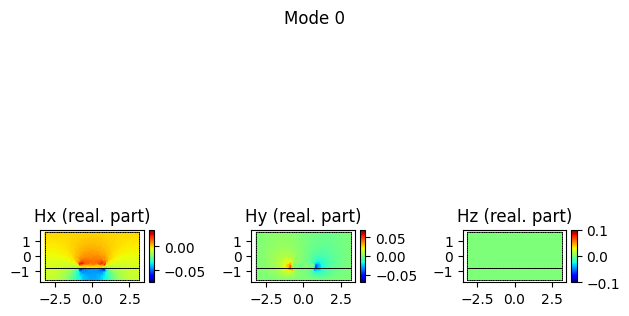

c:\Users\default.LAPTOP-HMRU58MH\anaconda3\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\stub_opt
loading problem from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\stub_opt



FileNotFoundError: [WinError 2] The system cannot find the file specified

In [10]:
# adaptive meshing
nres = 16
dx0 = wavelength / nres

layer_stack = LayerStack(
    layers={
        "design": LayerLevel(
            layer=LogicalLayer(layer=DESIGN),
            zmin=height_sub,
            thickness=thickness,
            material="design",
            mesh_order=0,
        ),
        "line": LayerLevel(
            layer=LogicalLayer(layer=WG),
            zmin=height_sub,
            thickness=thickness,
            material="PEC",
            mesh_order=3,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=BBOX),
            zmin=0.0,
            thickness=height_sub,
            material="substrate",
            mesh_order=4,
        ),
    }
)

n_line = dx0 / (w_line / 4)  # 10 mesh points across the strip
n_design = dx0 / (w_design / 10)  # 10 mesh points across the design area
eps_substrate = 4.3
nFR = np.sqrt(eps_substrate)
materials_library=   {
        'air': lumi.Material(),
        "design": lumi.PlaceholderMaterial(n_design),
        "substrate":lumi.Material(epsilon=eps_substrate),
        "PEC": lumi.PECMaterial(n_design),
        "background": lumi.Material(),
    }


modes = [
    lumi.Mode(frequency=frequency, metallic_boundaries=["-y", "line"], nmodes=1),
]

sources = [
    lumi.Source("o1", source_port_margin=source_port_margin, frequency=frequency,duration=1)
]

designs = [
    lumi.Design(
        name="d1",
        symmetries=['x'],
        layer=DESIGN,
        lmin=w_line,
        fill_material="PEC",
        void_material="air",
        uniform_along="z",
    )
]

targets = [
    lumi.Target(
        key=f"To2@0,o1@0",
        target=v,
        frequency=f,
        weight=1/len(frequencies),
    ) for f, v in zip(frequencies,[1,.5,0,.5,1])
]

optimizer = lumi.Optimizer(
    stoploss=0.2,  # stop loss threshold for optimization
    iters=50,  # max iters
)

Tsim=(2*l_line+source_port_margin+4*(w_design+l_design))/signal_wavelength

kwargs = dict(
    path=path,
    component=c,
    frequency=frequency,
    frequencies=frequencies,
    wl1f=wl1f,
    boundaries=["PML", "PML", ["PEC", "PML"]],
    #
    sources=sources,
    modes=modes,
    lateral_port_margin=lateral_port_margin,
    height_port_margin=[0,height_port_margin],
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    zmin=-0,
    zmax=height_sub + thickness + height_port_margin,
    #
    nres=nres,
    relative_courant=0.5,  # relative courant number between 0 and 1
    relative_pml_depths=[1, 0.3, 0.3],
    Tsim=Tsim,  # max time
    # visualization
    field_slices=[0, 0, height_sub / 2],
    geometry_slices=[0, 0, height_sub + thickness / 2],
    show_field="Ey",
    #
    force=True,  # override and delete simulation folder
    gpu="CUDA",
    #
    # field_decay_threshold=0.005,
    designs=designs,
    targets=targets,
    optimizer=optimizer,
)
lumi.make_prob(**kwargs)
lumi.solve(path)
# lumi.make_movie(path)


sol = lumi.load_sol(path)
x = frequencies
# y = lumi.query(sol, "To2@0,o1@0")
y = lumi.query(sol, "T2,1")
y = [10 * math.log10(v) for v in y]
# y = sol["dB"]["o2@0,o1@0"]
# y1 = sol["flux"]["o1-"]
# y2 = sol["flux"]["o1+"]
# plt.plot(x, y1, x, y2)
plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S21 [dB]")
plt.show()